# ATP Tennis Data - Player Diff Stats + One Hot Encoding (Player Only Data) + Matchup


In our previous [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/5.2-atp_diff-ohe.ipynb), we did not see any improvement from adding player match history leading up to match. In fact we saw a 1% performance decrease

In this notebook, we will add matchup history between player 1 and 2 to the data and see if this helps our performance

Data that we obtained for each player:

* matchups won - ie, out of last 5 matchups - how many matches did p1 win
* matchups lost
* matchups sets won
* matchups sets lost
* matchups games won
* matchups games lost
* matchups win percentage
* matchups sets won percentage
* matchups games won percentage

We will see if this data helps improve our models

### Results from Decision Tree Classifier with player diff + one hot encoded player ID's:

```
Model Score: 0.9372638963842418

              precision    recall  f1-score   support

        Loss       0.93      0.94      0.94      7378
         Win       0.94      0.93      0.94      7446

    accuracy                           0.94     14824
   macro avg       0.94      0.94      0.94     14824
weighted avg       0.94      0.94      0.94     14824
```

# Summary of Results


* Decision Tress is still our best model, although adding this data decreased our performance to be about 1% (back to diff+ohe_player performance). Our accuracty for both wins and losses are down to 92% now with lower recall as well

Player Diff + One Hot Encoding (All Categories) + Player History
```
Model Score: 0.9191851052347545

              precision    recall  f1-score   support

        Loss       0.92      0.92      0.92      7378
         Win       0.92      0.92      0.92      7446

    accuracy                           0.92     14824
   macro avg       0.92      0.92      0.92     14824
weighted avg       0.92      0.92      0.92     14824
```

Player Diff + One Hot Encoding (All Categories) + Player Matchup
```
Model Score: 0.9247841338370211

              precision    recall  f1-score   support

        Loss       0.92      0.93      0.92      7378
         Win       0.93      0.92      0.92      7446

    accuracy                           0.92     14824
   macro avg       0.92      0.92      0.92     14824
weighted avg       0.92      0.92      0.92     14824
```


* No change in performance for Ada Boost or Logistic regression or Gradient Boost
* Around 5% decrease in accuracy for KNN and Random Forest


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "diff-ohe-matchup"


# update this
FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-diff-ohe-matchup5.csv'

START_YEAR = 1998
END_YEAR = 2019

MODEL_TEMPLATE_NAME = f'{START_YEAR}-{END_YEAR}-{DESCRIPTION}.pkl'

LABEL_COL = 'p1_winner'

# random seed
RSTATE = 1
N_JOBS = 4
MAX_ITER = 100



ModelWrapper.init(description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR, 
                 model_file_format = MODEL_TEMPLATE_NAME)

In [2]:
X_train, X_test, y_train, y_test = ju.get_data(FEATURE_FILE, LABEL_COL, START_YEAR)

(59293, 5283)


Our dataset actually has both historical data as well as matchup data. We will remove the matchup columns from the dataset

In [7]:
import re
history_columns = [col for col in X_train.columns if re.search(r"(p1|p2)_(win|loss|set|game)", col)]

print(history_columns)

# there should be 18 columns
assert len(history_columns) == 18, "mismsatched number of columns"

print(f'Before: X_train.shape {X_train.shape} X_test.shape {X_test.shape}')
X_train = X_train.drop(history_columns, axis=1)
X_test = X_test.drop(history_columns, axis=1)
print(f'After: X_train.shape {X_train.shape} X_test.shape {X_test.shape}')

['p1_games_lost', 'p1_games_won', 'p1_games_won_percentage', 'p1_losses', 'p1_sets_lost', 'p1_sets_won', 'p1_sets_won_percentage', 'p1_win_percentage', 'p1_wins', 'p2_games_lost', 'p2_games_won', 'p2_games_won_percentage', 'p2_losses', 'p2_sets_lost', 'p2_sets_won', 'p2_sets_won_percentage', 'p2_win_percentage', 'p2_wins']
Before: X_train.shape (44469, 5283) X_test.shape (14824, 5283)
After: X_train.shape (44469, 5265) X_test.shape (14824, 5265)


# Logistic Regression

In [8]:

# train our model

lr = ModelWrapper(LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
                   X_train,
                   y_train,
                   X_test,
                   y_test).fit()
y_predict_lr = lr.predict()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

Model Score: 0.6690501888828926

              precision    recall  f1-score   support

        Loss       0.67      0.67      0.67      7378
         Win       0.67      0.67      0.67      7446

    accuracy                           0.67     14824
   macro avg       0.67      0.67      0.67     14824
weighted avg       0.67      0.67      0.67     14824

      Loss   Win
Loss  4907  2471
Win   2435  5011


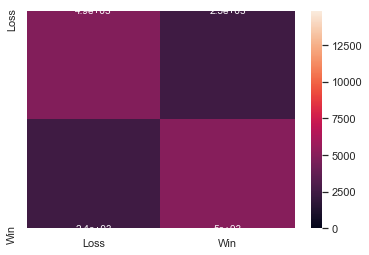

In [9]:
lr.analyze()

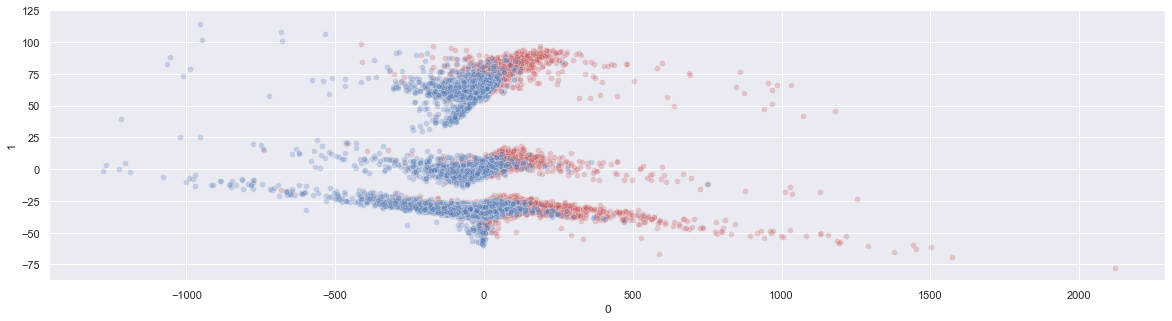

In [10]:
ju.plot_2d(X_test, y_predict_lr)

In [11]:
lr.save()

# KNN

In [12]:

# train our model

knn = ModelWrapper(KNeighborsClassifier(n_jobs = N_JOBS),
                   X_train,
                   y_train,
                   X_test,
                   y_test).fit()
y_predict_knn = knn.predict()

Model Score: 0.8324338909875877

              precision    recall  f1-score   support

        Loss       0.82      0.85      0.83      7378
         Win       0.85      0.81      0.83      7446

    accuracy                           0.83     14824
   macro avg       0.83      0.83      0.83     14824
weighted avg       0.83      0.83      0.83     14824

      Loss   Win
Loss  6272  1106
Win   1378  6068


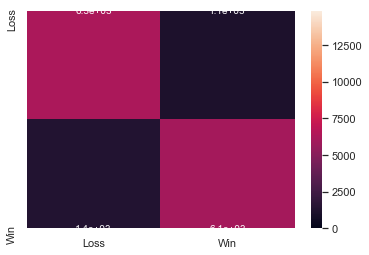

In [13]:
knn.analyze()

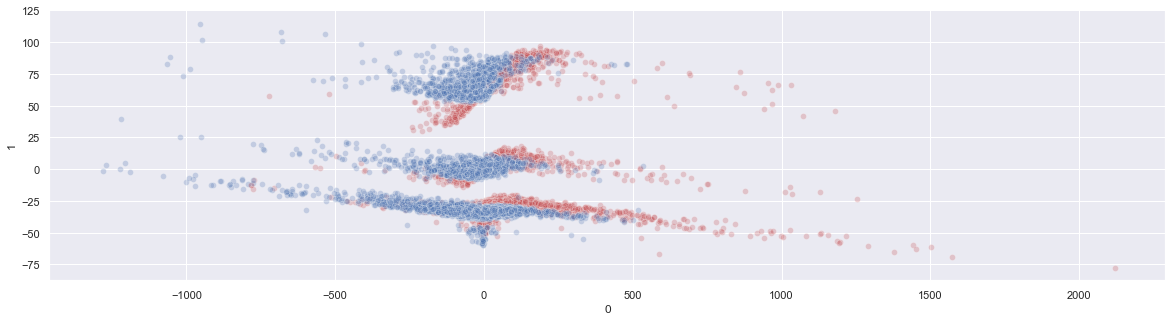

In [14]:
ju.plot_2d(X_test, y_predict_knn)

In [15]:
knn.save()

# Decision Tree

In [16]:

# train our model

dt = ModelWrapper(DecisionTreeClassifier(random_state = RSTATE),
                   X_train,
                   y_train,
                   X_test,
                   y_test).fit()
y_predict_dt = dt.predict()

Model Score: 0.9247841338370211

              precision    recall  f1-score   support

        Loss       0.92      0.93      0.92      7378
         Win       0.93      0.92      0.92      7446

    accuracy                           0.92     14824
   macro avg       0.92      0.92      0.92     14824
weighted avg       0.92      0.92      0.92     14824

      Loss   Win
Loss  6845   533
Win    582  6864


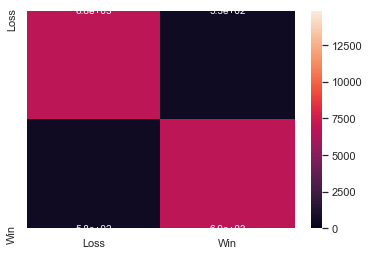

In [17]:
dt.analyze()

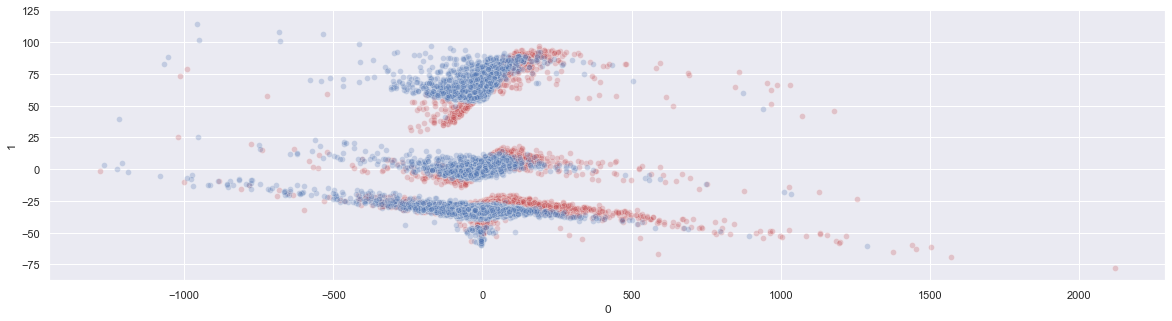

In [18]:
ju.plot_2d(X_test, y_predict_dt)

In [19]:
dt.save()

# Random Forest Classifier

In [20]:

# train our model

rf = ModelWrapper(RandomForestClassifier(random_state=RSTATE, verbose=1),
                   X_train,
                   y_train,
                   X_test,
                   y_test).fit()
y_predict_rf = rf.predict()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Model Score: 0.7740825688073395

              precision    recall  f1-score   support

        Loss       0.75      0.81      0.78      7378
         Win       0.80      0.74      0.77      7446

    accuracy                           0.77     14824
   macro avg       0.78      0.77      0.77     14824
weighted avg       0.78      0.77      0.77     14824

      Loss   Win
Loss  5984  1394
Win   1955  5491


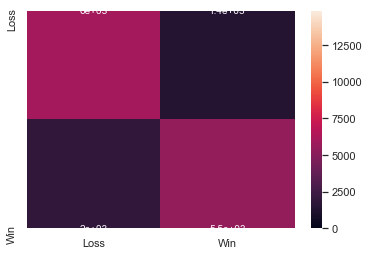

In [21]:
rf.analyze()

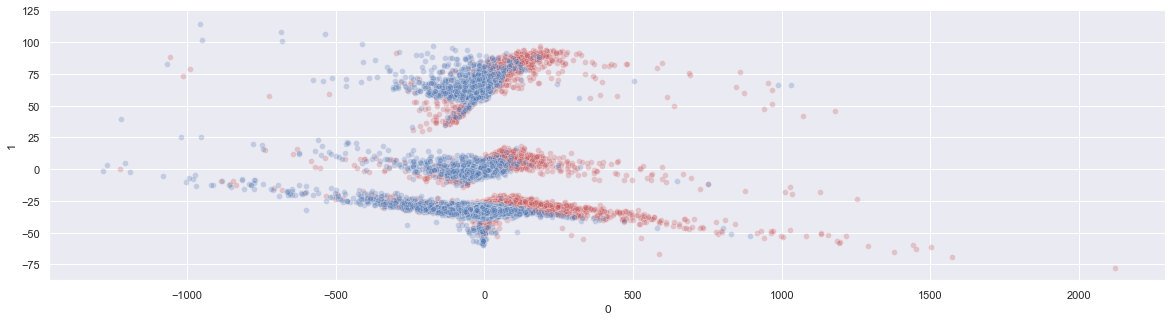

In [22]:
ju.plot_2d(X_test, y_predict_rf)

In [23]:
rf.save()

# Gradient Boosting

In [24]:

# train our model

gb = ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                   X_train,
                   y_train,
                   X_test,
                   y_test).fit()
y_predict_gb = gb.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3153            9.64m
         2           1.2572            9.50m
         3           1.2087            9.31m
         4           1.1699            9.18m
         5           1.1376            9.33m
         6           1.1111            9.51m
         7           1.0795            9.32m
         8           1.0528            9.15m
         9           1.0318            8.98m
        10           1.0104            8.84m
        20           0.8858            7.67m
        30           0.8207            6.64m
        40           0.7839            5.70m
        50           0.7628            4.70m
        60           0.7434            3.76m
        70           0.7238            2.82m
        80           0.6953            1.89m
        90           0.6691           56.51s
       100           0.6470            0.00s


Model Score: 0.8656907717215326

              precision    recall  f1-score   support

        Loss       0.85      0.89      0.87      7378
         Win       0.88      0.84      0.86      7446

    accuracy                           0.87     14824
   macro avg       0.87      0.87      0.87     14824
weighted avg       0.87      0.87      0.87     14824

      Loss   Win
Loss  6544   834
Win   1157  6289


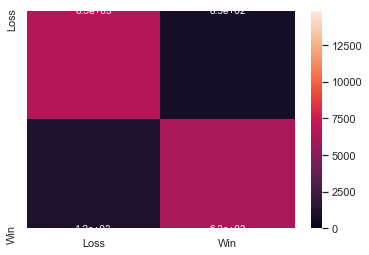

In [25]:
gb.analyze()

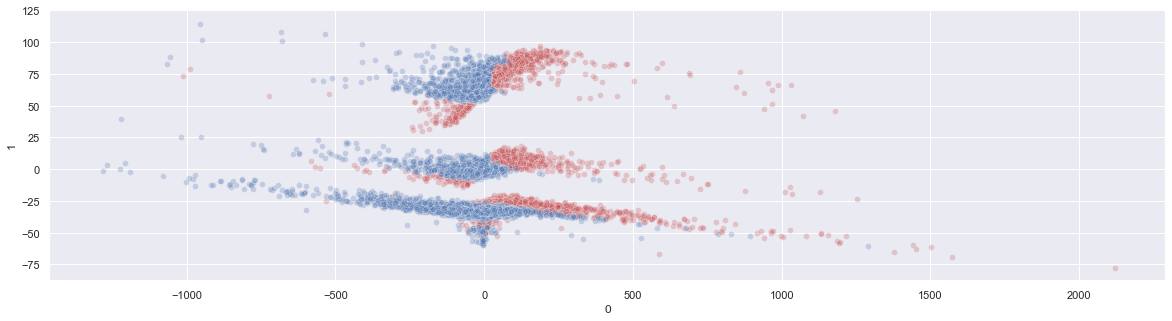

In [26]:
ju.plot_2d(X_test, y_predict_gb)

In [27]:
gb.save()

# AdaBoost

In [28]:
ab = ModelWrapper(AdaBoostClassifier(random_state=RSTATE),
                   X_train,
                   y_train,
                   X_test,
                   y_test).fit()
y_predict_ab = ab.predict()

Model Score: 0.7600512682137075

              precision    recall  f1-score   support

        Loss       0.74      0.79      0.77      7378
         Win       0.78      0.73      0.75      7446

    accuracy                           0.76     14824
   macro avg       0.76      0.76      0.76     14824
weighted avg       0.76      0.76      0.76     14824

      Loss   Win
Loss  5851  1527
Win   2030  5416


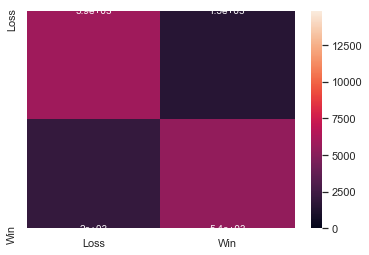

In [29]:
ab.analyze()

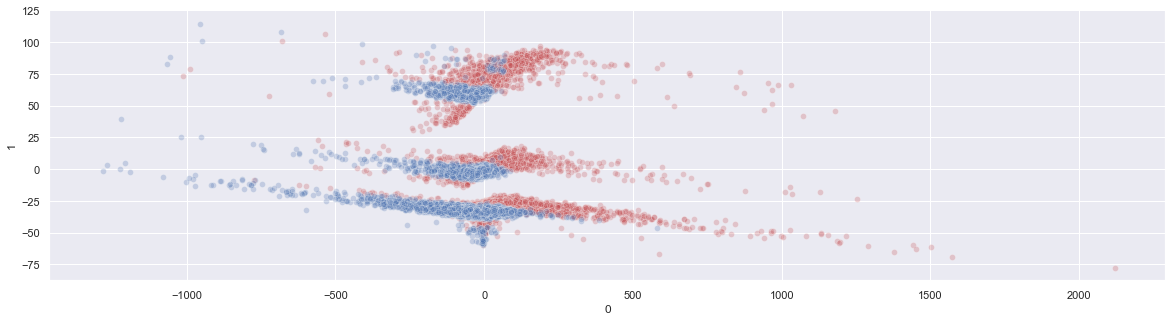

In [30]:
ju.plot_2d(X_test, y_predict_ab)

In [31]:
ab.save()

# Results

* Decision Tress is still our best model, although adding this data decreased our performance to be about 1% (from diff+ohe_player performance)
* No change in performance for Ada Boost or Logistic regression or Gradient Boost
* Around 5% decrease in accuracy for KNN and Random Forest

In [32]:
report = pd.read_csv(ModelWrapper.report_file)
report.tail(5)

,model,description,data_file,start_year,accuracy,confusion_matrix,classification_report,model_file
25,KNeighborsClassifier,diff-ohe-matchup,../datasets/atp_matches_1985-2019_features-dif...,1998,0.832434,"{""0"": {""0"": 6272, ""1"": 1378}, ""1"": {""0"": 1106,...","{""Loss"": {""precision"": 0.8198692810457516, ""re...",../models/kneighborsclassifier-1998-2019-diff-...
26,DecisionTreeClassifier,diff-ohe-matchup,../datasets/atp_matches_1985-2019_features-dif...,1998,0.924784,"{""0"": {""0"": 6845, ""1"": 582}, ""1"": {""0"": 533, ""...","{""Loss"": {""precision"": 0.9216372694223778, ""re...",../models/decisiontreeclassifier-1998-2019-dif...
27,RandomForestClassifier,diff-ohe-matchup,../datasets/atp_matches_1985-2019_features-dif...,1998,0.774083,"{""0"": {""0"": 5984, ""1"": 1955}, ""1"": {""0"": 1394,...","{""Loss"": {""precision"": 0.7537473233404711, ""re...",../models/randomforestclassifier-1998-2019-dif...
28,GradientBoostingClassifier,diff-ohe-matchup,../datasets/atp_matches_1985-2019_features-dif...,1998,0.865691,"{""0"": {""0"": 6544, ""1"": 1157}, ""1"": {""0"": 834, ...","{""Loss"": {""precision"": 0.8497597714582522, ""re...",../models/gradientboostingclassifier-1998-2019...
29,AdaBoostClassifier,diff-ohe-matchup,../datasets/atp_matches_1985-2019_features-dif...,1998,0.760051,"{""0"": {""0"": 5851, ""1"": 2030}, ""1"": {""0"": 1527,...","{""Loss"": {""precision"": 0.742418474812841, ""rec...",../models/adaboostclassifier-1998-2019-diff-oh...


Text(0.5, 1.0, 'Model Accuracy')

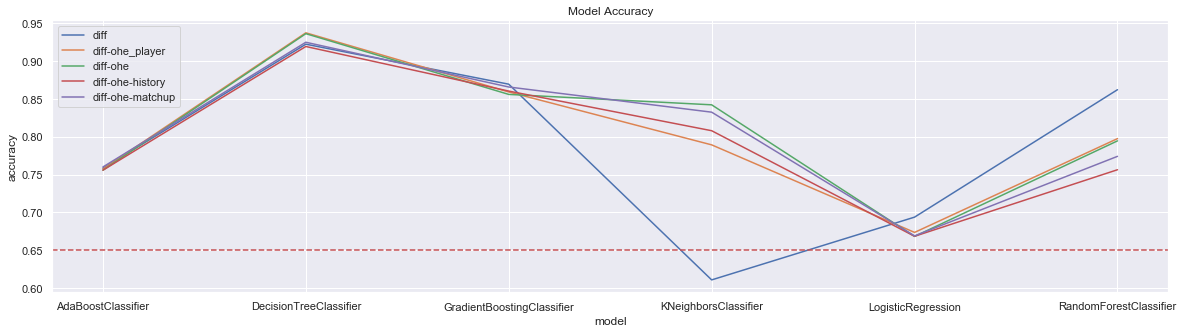

In [33]:
f, a = plt.subplots(1, 1, figsize=(20, 5))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    sns.lineplot(x="model", y="accuracy", data=report_desc, label=desc)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")